In [0]:
# Import the machine learning libraries.
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

In [32]:
# Get the stock quote of Apple Inc.
df = web.DataReader('GOOGL', data_source='yahoo', start='2007-01-01', end='2020-08-08') 
df.head(10)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2007-01-03,238.568573,230.785782,233.233231,234.029022,15397500.0,234.029022
2007-01-04,242.217224,234.409409,234.734741,241.871872,15759400.0,241.871872
2007-01-05,243.993988,239.294296,241.491486,243.838837,13730400.0,243.838837
2007-01-08,245.180176,241.341339,244.089096,242.032028,9499200.0,242.032028
2007-01-09,244.369370,240.840836,242.967972,242.992996,10752000.0,242.992996
2007-01-10,247.022018,241.261261,242.457458,244.974976,11925000.0,244.974976
2007-01-11,251.126129,248.338333,248.848846,250.110107,14401900.0,250.110107
2007-01-12,252.752747,250.250244,251.246246,252.752747,8938400.0,252.752747
2007-01-16,256.756744,251.901901,254.029022,252.392395,15122600.0,252.392395


In [33]:
df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,3361.000000,3361.000000,3361.000000,3361.000000,3.361000e+03,3361.000000
mean,582.672354,571.822391,577.442020,577.405672,4.888180e+06,577.405672
std,358.527156,352.265274,355.408565,355.606940,4.500720e+06,355.606940
min,134.819824,123.773773,131.386383,128.848846,5.206000e+05,128.848846
25%,279.144135,272.197205,275.655670,275.535522,1.734100e+06,275.535522
50%,449.674683,443.533539,447.697693,446.976990,3.595600e+06,446.976990
75%,828.469971,817.000000,823.130005,821.630005,6.253100e+06,821.630005
max,1530.739990,1520.979980,1527.199951,1524.869995,4.652800e+07,1524.869995


In [34]:
print(df.shape)

(3361, 6)


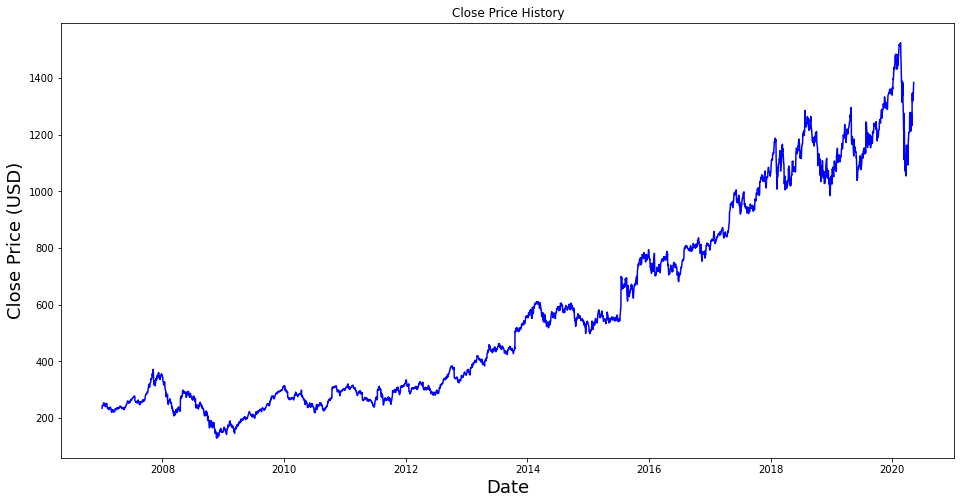

In [35]:
# Visualize the closing price history.
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'], color='b')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

In [0]:
# Create a new dataframe with only the 'Close' column.
data = df.filter(['Close'])
# Converting the dataframe to a numpy array.
dataset = data.values
# Compute the number of rows to train the model on.
training_data_len = math.ceil( len(dataset) *.8) 

In [0]:
# Min-Max Normalization.
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [0]:
# Create the scaled training dataset.
train_data = scaled_data[0:training_data_len, :]

# Split the data into X_train and y_train data sets
X_train=[]
y_train = []
for i in range(60,len(train_data)):
    X_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [0]:
# Convert x_train and y_train to numpy arrays.
X_train, y_train = np.array(X_train), np.array(y_train)

In [0]:
# Reshape the data into the shape accepted by the LSTM.
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [41]:
# Build the LSTM network model.
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_3 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


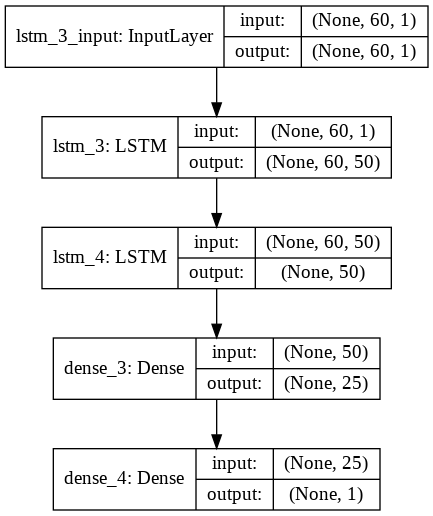

In [42]:
# Visualize.
from keras.utils import plot_model
plot_model(model, show_shapes=True)

In [0]:
# Compile the model.
model.compile(optimizer='adam', loss='mean_squared_error')

In [44]:
# Train the model.
model.fit(X_train, y_train, batch_size=1, epochs=1)

Epoch 1/1
2629/2629 [==============================] - 99s 38ms/step - loss: 5.0885e-04


In [0]:
# Test dataset.
test_data = scaled_data[training_data_len-60:, :]

# Create the x_test and y_test datasets.
X_test = []
y_test =  dataset[training_data_len:, :]
for i in range(60,len(test_data)):
    X_test.append(test_data[i-60:i, 0])

In [0]:
# Convert x_test to a numpy array.
X_test = np.array(X_test)

In [0]:
# Reshape the data into the shape accepted by the LSTM.
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [0]:
# Getting the models predicted price values.
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions) #Undo scaling

In [49]:
# Calculate/Get the value of RMSE.
rmse = np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

36.21032497337663

In [50]:
# Plot/Create the data for the graph.
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


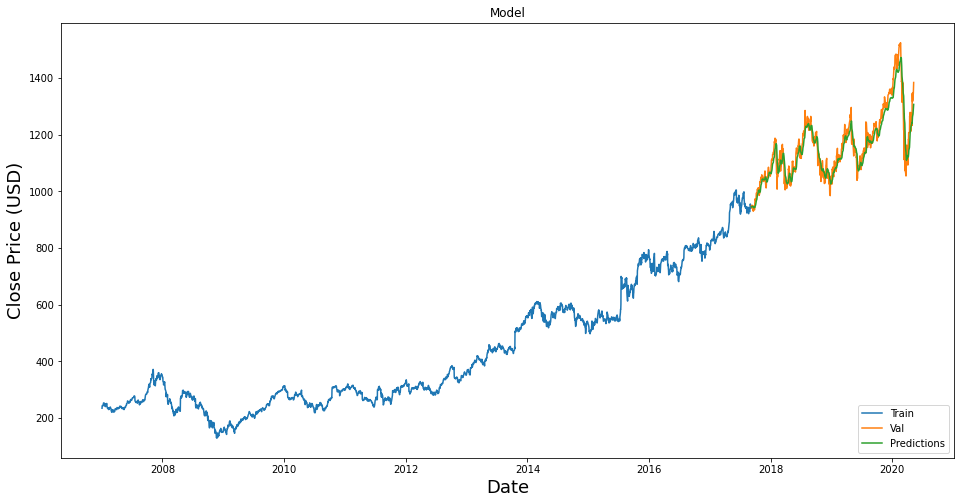

In [51]:
# Visualize the data.
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price (USD)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [52]:
# Show the valid and predicted prices.
valid

,Close,Predictions
Date,,
2017-09-07,949.890015,944.809326
2017-09-08,941.409973,945.909424
2017-09-11,943.289978,946.134033
2017-09-12,946.650024,946.139343
2017-09-13,950.440002,946.371277
...,...,...
2020-05-04,1322.900024,1272.600708
2020-05-05,1349.020020,1280.628540
2020-05-06,1345.430054,1289.731201


In [0]:
# Get the quote.
apple_quote = web.DataReader('GOOGL', data_source='yahoo', start='2007-01-01', end='2020-08-08')

In [0]:
# Create a new dataframe.
new_df = apple_quote.filter(['Close'])

In [0]:
# Get the last 60 day closing price.
last_60_days = new_df[-60:].values

In [0]:
# Scale the data to be values between 0 and 1.
last_60_days_scaled = scaler.transform(last_60_days)

In [0]:
# Create an empty list.
X_test = []

# Append teh past 60 days.
X_test.append(last_60_days_scaled)

# Convert the X_test data set to a numpy array.
X_test = np.array(X_test)

In [0]:
# Reshape the data.
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [0]:
# Get the predicted scaled price.
pred_price = model.predict(X_test)

In [60]:
# Undo the scaling.
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[1317.0579]]
